# Load Pretrained weights into Resnet Model

In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
from importlib.util import find_spec
if find_spec("model") is None:
    import sys
    sys.path.append('..')

In [14]:
from torchvision.models import resnet50

In [15]:
from model.backbone.resnet import ResNet50

In [4]:
pretrained_model = resnet50(pretrained=True)

In [5]:
model = ResNet50(num_classes=1000)

In [6]:
len(model.state_dict().items())

320

In [7]:
len(pretrained_model.state_dict().items())

320

In [8]:
new = list(pretrained_model.state_dict().items())

In [9]:
model_dict = model.state_dict()
count = 0
for k, v in model_dict.items():
    layer_name, weights = new[count]
    model_dict[k] = weights
    count += 1

In [4]:
model = ResNet50(pretrained=True)

## Test Model Loading with FastAI Pets dataset

Following [FastAI Walk CoLab](https://colab.research.google.com/github/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/01_Pets.ipynb#scrollTo=_85VW_jT3gJk)

In [3]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [4]:
path = untar_data(URLs.PETS)

In [5]:
np.random.seed(2)

In [6]:
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

In [7]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1., 1.))
bs = 64

### Using Highest Level API

In [8]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, item_tfms=item_tfms, bs=bs)

### Using Medium Level API

In [15]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat=pat),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms
                )

In [16]:
path_im = path/'images'

In [17]:
dls = pets.dataloaders(path_im, bs=bs)

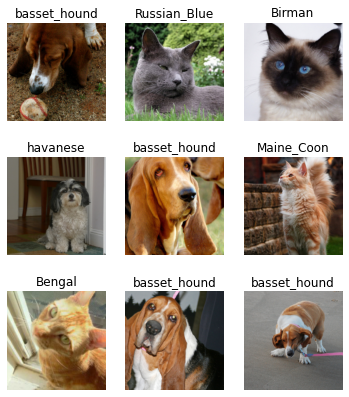

In [10]:
dls.show_batch(max_n=9, figsize=(6,7))

In [19]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss())

In [20]:
learn.fit_one_cycle(4)

../model/backbone/resnet.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


../model/backbone/resnet.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=1.3182567499825382e-06)

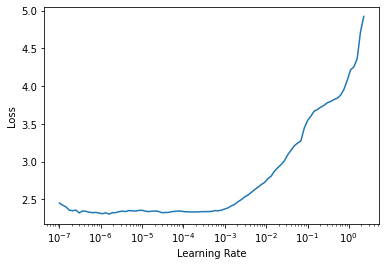

In [21]:
learn.lr_find()

In [23]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(4, 1.32e-6)

../model/backbone/resnet.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


### Build Custom Model for Pets Model

Following [Fast AI Tutorial](https://docs.fast.ai/tutorial.siamese)

In [9]:
class PetsModel(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head
        
    def forward(self, x):
        return self.head(self.encoder(x))

In [11]:
encoder = create_body(ResNet50, cut=-2)

In [12]:
encoder[-1]

Sequential(
  (0): BottleNeckBlock(
    (block): Sequential(
      (0): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential(
      (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (1): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BottleNeckBlock(
    (block): Sequential(
      (0): Conv2d(2048, 512, kernel_siz

In [13]:
len(encoder.state_dict().items())

318

In [14]:
head = create_head(2048 * 2, 37, ps=0.5)
model = PetsModel(encoder, head)

In [15]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

In [16]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss())

In [17]:
learn.freeze()

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.00010964782268274575)

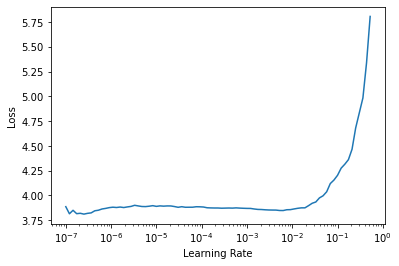

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(4, 6e-4)

SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=1.3182567499825382e-06)

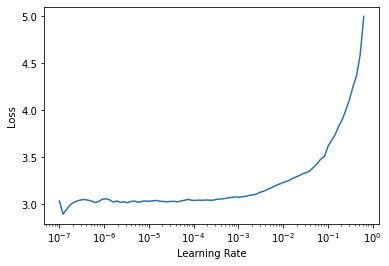

In [20]:
learn.lr_find()

In [21]:
learn.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=9.12010818865383e-07)

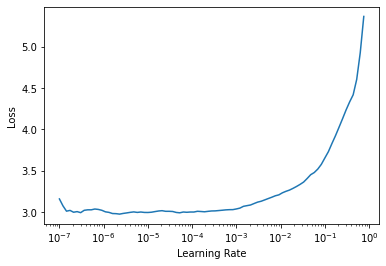

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(4, slice(1e-6,1e-4))

### Using Pytorch ResNet50 Model

In [12]:
import torchvision.models as models

In [13]:
encoder = create_body(models.resnet50, cut=-2)

In [14]:
encoder[-1]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [15]:
head = create_head(2048 * 2, 37)
model = PetsModel(encoder, head)

In [16]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss())

In [17]:
learn.freeze()

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.0002754228771664202)

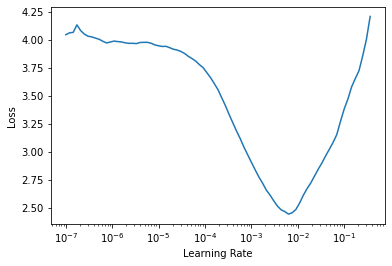

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(4, 2e-4)

# Preload ResNet50

In [16]:
pretrained_model = resnet50(pretrained=True)
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
len(pretrained_model.state_dict().items())

320

In [18]:
from model.backbone.resnet import resnet50

In [19]:
model = resnet50(num_classes=1000)
model

ResNet(
  (stem): StandardStem(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res2): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(6

In [20]:
len(model.state_dict().items())

320

In [21]:
pretrained_dict = pretrained_model.state_dict()
model_dict = model.state_dict()

In [22]:
for k, v in model_dict.items():
    print(f"key: {k}")

key: stem.conv1.weight
key: stem.bn1.weight
key: stem.bn1.bias
key: stem.bn1.running_mean
key: stem.bn1.running_var
key: stem.bn1.num_batches_tracked
key: res2.0.conv1.weight
key: res2.0.bn1.weight
key: res2.0.bn1.bias
key: res2.0.bn1.running_mean
key: res2.0.bn1.running_var
key: res2.0.bn1.num_batches_tracked
key: res2.0.conv2.weight
key: res2.0.bn2.weight
key: res2.0.bn2.bias
key: res2.0.bn2.running_mean
key: res2.0.bn2.running_var
key: res2.0.bn2.num_batches_tracked
key: res2.0.conv3.weight
key: res2.0.bn3.weight
key: res2.0.bn3.bias
key: res2.0.bn3.running_mean
key: res2.0.bn3.running_var
key: res2.0.bn3.num_batches_tracked
key: res2.0.downsample.0.weight
key: res2.0.downsample.1.weight
key: res2.0.downsample.1.bias
key: res2.0.downsample.1.running_mean
key: res2.0.downsample.1.running_var
key: res2.0.downsample.1.num_batches_tracked
key: res2.1.conv1.weight
key: res2.1.bn1.weight
key: res2.1.bn1.bias
key: res2.1.bn1.running_mean
key: res2.1.bn1.running_var
key: res2.1.bn1.num_batc

In [23]:
new = list(pretrained_dict.items())

In [58]:
model_dict = model.state_dict()
count = 0
for k, v in model_dict.items():
    layer_name, weights = new[count]
    model_dict[k] = weights
    count += 1
    
model.load_state_dict(model_dict)

<All keys matched successfully>

In [25]:
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path

In [26]:
def read_img(path: Path, name="img"):
    img = cv.imread(str(path))
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.show()
    return rgb

In [27]:
root = Path("./images/")

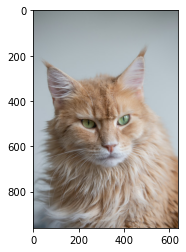

In [28]:
img = read_img(root/"cat.jpg")

In [29]:
type(img)

numpy.ndarray

In [37]:
import torch

In [31]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

In [33]:
from PIL import Image

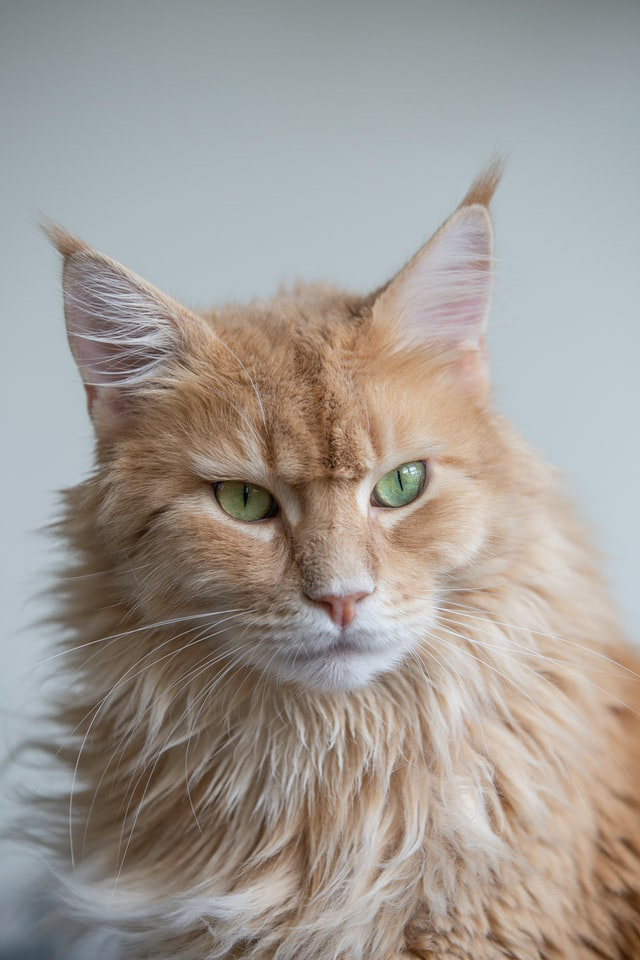

In [35]:
img = Image.open(root/"cat.jpg")
img

In [38]:
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)

In [39]:
model.eval()

ResNet(
  (stem): StandardStem(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res2): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(6

In [40]:
out = model(batch_t)
out

{'fc': tensor([[-1.7384e+02,  1.6837e+02,  1.0022e+02,  3.1416e+02, -5.9971e+01,
           5.7567e+02, -1.6384e+01,  1.6920e+01,  1.4621e+02, -6.7182e+01,
          -1.1256e+02,  1.4010e+02,  2.8169e+02, -1.2218e+02,  2.0277e+02,
          -4.4111e+02, -3.8499e+02, -2.3489e+02,  6.0554e+02,  2.8295e+02,
           1.3633e+02,  6.3771e+02,  5.8416e+02,  6.3710e+02, -5.1140e+01,
           4.4578e+02, -1.3691e+02,  2.9821e+02,  5.3712e+02, -1.7255e+02,
           5.7034e+02, -2.0404e+02, -1.0633e+03, -2.3903e+02, -5.3396e+02,
          -2.3155e+02, -4.5593e-01, -1.4238e+02,  5.7259e+01,  3.6728e+01,
          -3.3603e+02,  1.0158e+02, -4.9319e+02,  6.3645e+02, -4.9915e+02,
           1.8915e+02, -1.0536e+02,  1.0410e+02, -8.9541e+02,  1.6017e+02,
          -1.4773e+02,  1.9554e+02, -5.0003e+02, -1.0805e+03, -2.0988e+02,
           4.7196e+02,  9.0673e+02,  1.8500e+02,  1.1398e+03,  5.0500e+01,
          -3.0915e+02, -3.5298e+02,  2.0664e+02, -2.2683e+02, -5.9480e+02,
           5.3433e+

In [42]:
_, index = torch.max(out["fc"], 1)
index

tensor([277])

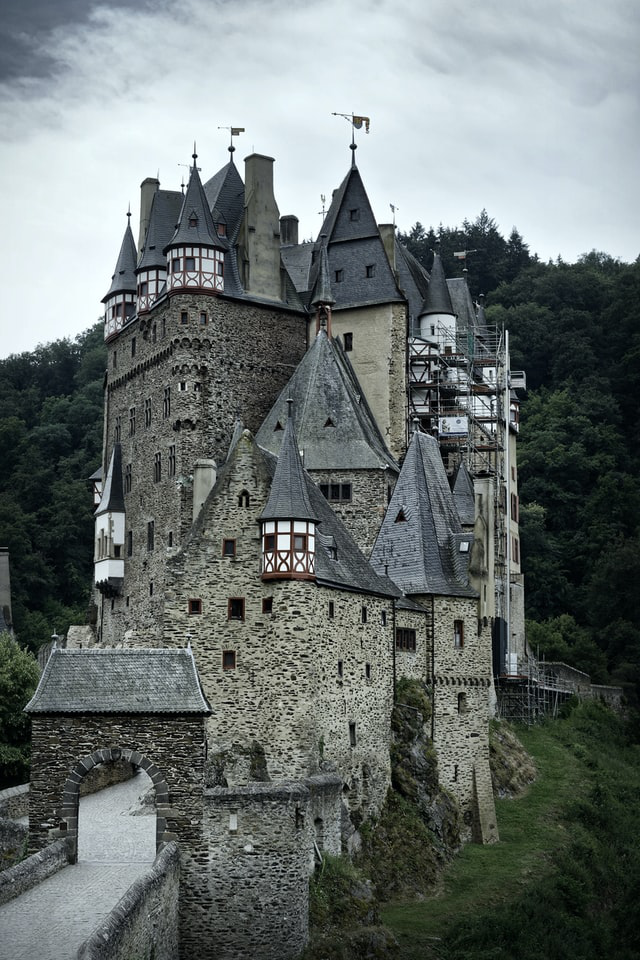

In [64]:
img = Image.open(root/"castle.jpg")
img

In [79]:
def make_prediction(model, img):
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    out = model(batch_t)
    _, index = torch.max(out["fc"], 1)
    print(index.item())
    return index.item()
    
def make_prediction2(model, img):
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    out = model(batch_t)
    _, index = torch.max(out, 1)
    print(index.item())
    return index.item()
    

In [66]:
make_prediction(model, img)

tensor([483])


In [67]:
pretrained_model.eval();

In [68]:
make_prediction2(pretrained_model, img)

tensor([483])


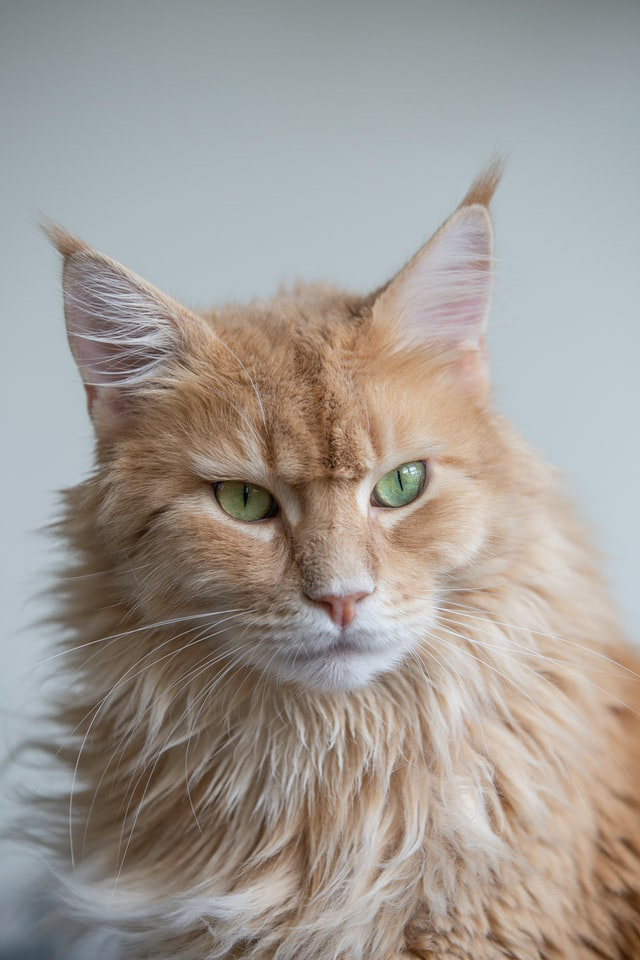

In [69]:
img = Image.open(root/"cat.jpg")
img

In [71]:
make_prediction(model, img)
make_prediction2(pretrained_model, img)

tensor([281])
tensor([282])


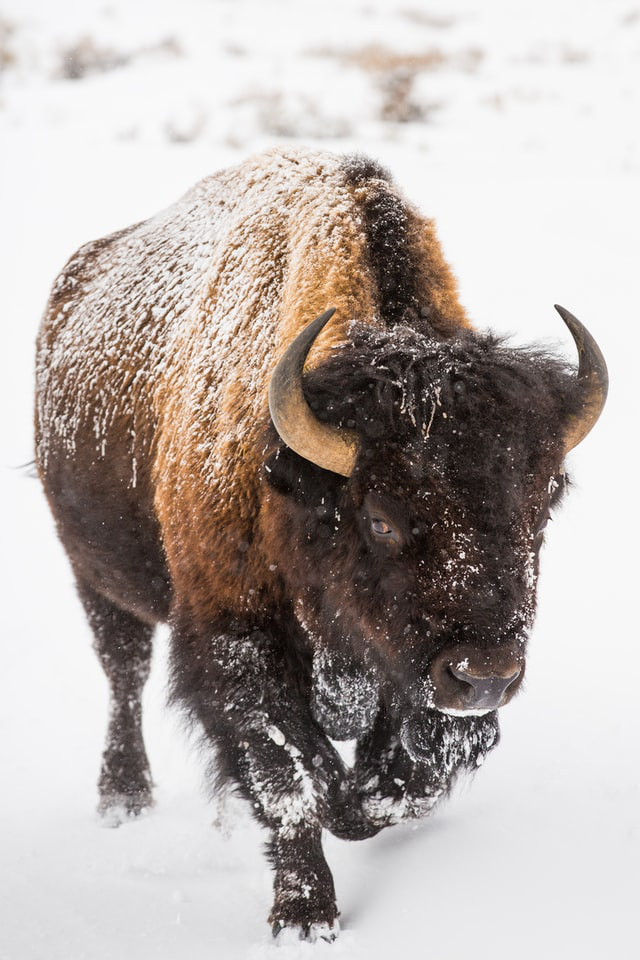

In [72]:
img = Image.open(root/"bison.jpg")
img

In [73]:
make_prediction(model, img)
make_prediction2(pretrained_model, img)

tensor([347])
tensor([347])


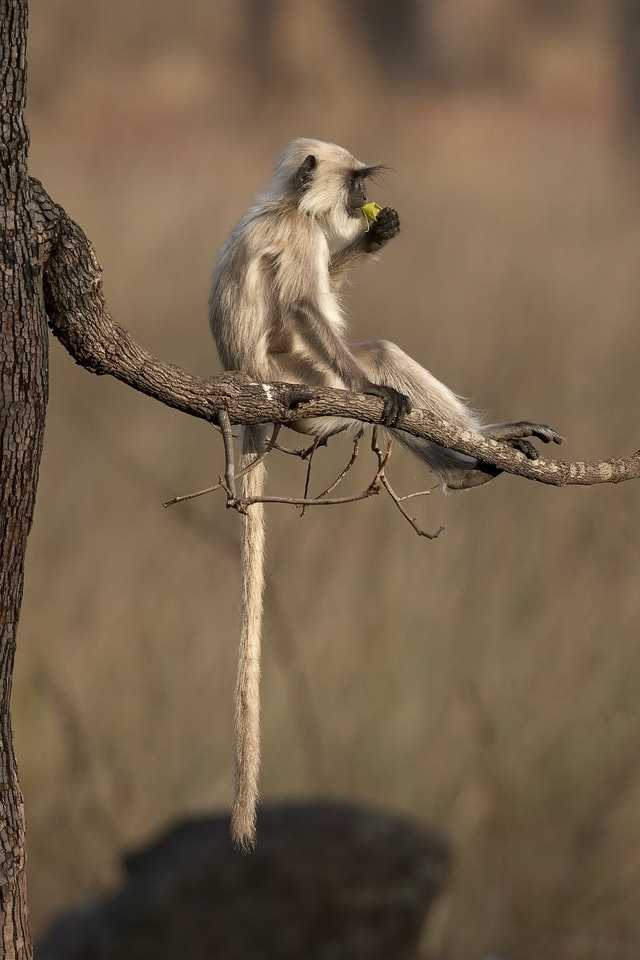

In [74]:
img = Image.open(root/"languar.jpg")
img

In [81]:
make_prediction(model, img)
make_prediction2(pretrained_model, img);

374
374


In [76]:
with open("imagenet_classes.txt") as f:
    idx2label = eval(f.read())

In [83]:
idx2label[make_prediction(model, img)]

374


'langur'

In [85]:
idx2label[make_prediction2(pretrained_model, img)]

374


'langur'